# Group-based Regression Models

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [4]:
from pycaret.regression import *

In [5]:
import functions as f

# Metal Oxides regression model

In [6]:
model_name = "oxide"
group_name = "meta_oxide"
seed = 123

### Load the data and filter metal oxide instances

In [7]:
data_train_df = pd.read_csv("output/datasets/universal/data_regression_train_df.csv", encoding="utf-8")
data_test_df = pd.read_csv("output/datasets/universal/data_regression_test_df.csv", encoding="utf-8")
data_df = pd.concat([data_train_df,data_test_df])

del data_train_df
del data_test_df

In [8]:
data_df.shape

(11315, 20)

In [9]:
data_group_df = data_df[data_df['nanomaterial_group'] == group_name]

In [10]:
data_group_df.shape

(4082, 20)

In [11]:
data_group_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,Viability
3,Al2O3,None,44.00,372.3,-20.2,NaN,NaN,100.0,NaN,HaCat,Human,Skin,Keratinocyte,Adult,Normal,male,CytoTox-Glo,Dead-Cell-Protease,meta_oxide,81.60
5,ZnO,None,45.30,310.0,32.7,NaN,Sphere,100.0,12.0,HCMEC,Human,Heart,Endothelial,Adult,Normal,NaN,MTT,TetrazoliumSalt,meta_oxide,33.22
10,TiO2,None,125.00,1054.0,-40.8,38.0,NaN,50.0,12.0,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,meta_oxide,80.51
16,SiO2,NH2,289.56,NaN,21.7,NaN,Sphere,125.0,12.0,PC12,Rat,Adrenal-gland,Irregular,Adult,cancer,male,MTT,TetrazoliumSalt,meta_oxide,106.95
20,SiO2,None,12.00,96.0,-11.0,NaN,NaN,0.0,24.0,Caco_2,Human,Colon,Epithelial,Adult,cancer,male,LDH,LDHrelease,meta_oxide,105.37


### Create training set and test set

In [12]:
data_group_df = f.quantile_discretize(data_group_df, 'Viability')

In [13]:
splitter = setup(data = data_group_df, target = 'Viability_discrete',
                 preprocess = False,
                 train_size=0.8,
                 data_split_stratify=True,
                 # don't change the following
                 session_id = seed,
                 use_gpu=False,
                 log_experiment = False,
                 silent=True,
                 experiment_name = 'splitter')

,Description,Value
0,session_id,123
1,Target,Viability_discrete
2,Original Data,"(4082, 21)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,13
6,Transformed Train Set,"(3265, 20)"
7,Transformed Test Set,"(817, 20)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,True


In [14]:
data_group_train_df = get_config(variable="X_train").copy()
#data_group_train_df['Viability'] = get_config(variable="y_train").copy()

data_group_test_df = get_config(variable="X_test").copy()
#data_group_test_df['Viability'] = get_config(variable="y_test").copy()

In [15]:
print(data_group_train_df.shape)
print(data_group_test_df.shape)

(3265, 20)
(817, 20)


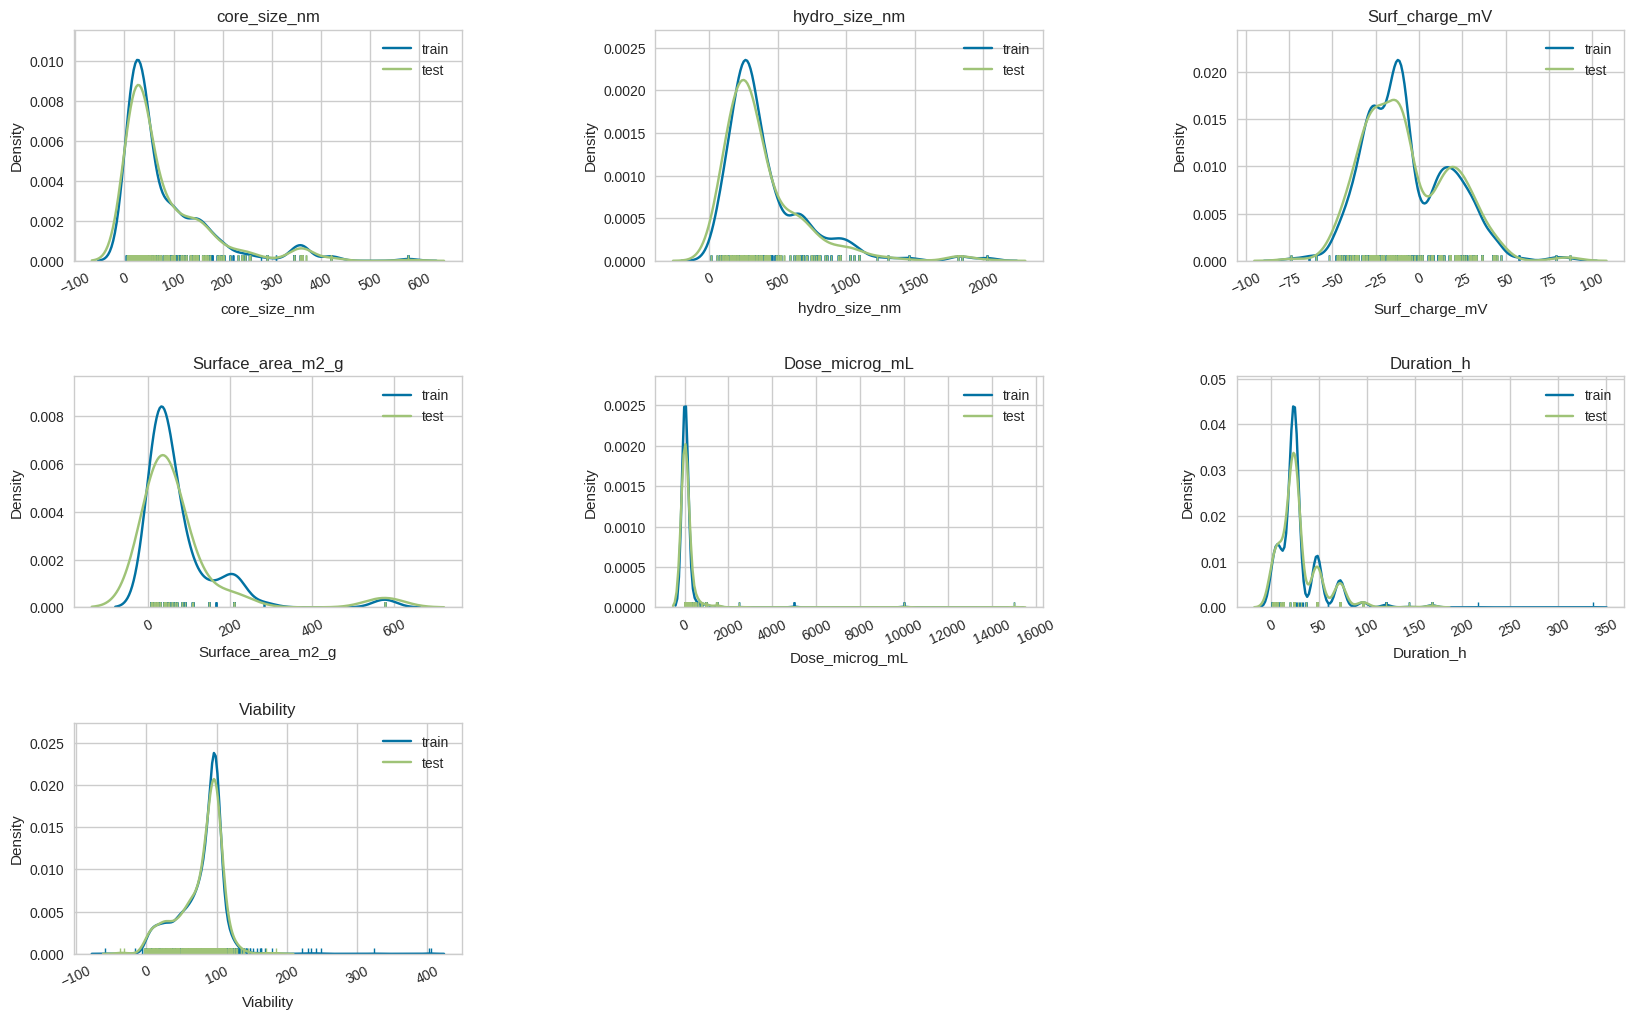

In [16]:
f.plot_distribution_train_test(data_group_train_df, data_group_test_df)

### Save cleaned datasets

In [21]:
data_group_train_df.to_csv('output/datasets/'+model_name+'/data_regression_'+model_name+'_train_df.csv', encoding='utf-8', index=False)

In [22]:
data_group_test_df.to_csv('output/datasets/'+model_name+'/data_regression_'+model_name+'_test_df.csv', encoding='utf-8', index=False)

### Use the best scenario identified in step 01

In [25]:
sc_ignore_features = ['nanomaterial_group', 'Coating', 'Cell_name']
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'iterative'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = True

### Data Preprcoessing

In [26]:
stup = setup(data = data_group_train_df, target = 'Viability', 
              
        test_data = data_group_test_df,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        # don't change the following
        session_id = seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = model_name)

set_config('seed', seed)

,Description,Value
0,session_id,123
1,Target,Viability
2,Original Data,"(3265, 20)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3086, 100)"


In [27]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(3086, 100)
(3086,)


In [28]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(3265, 100)
(3265,)


In [29]:
set_config('X_train', get_config(variable="X").copy()) 
set_config('y_train', get_config(variable="y").copy()) 

In [30]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(3265, 100)
(3265,)


In [31]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(817, 100)
(817,)


In [32]:
#load_config('output/models/universal_regression_rf.cfg')

In [33]:
data_group_train_transformed_df = get_config(variable="X").copy()
data_group_train_transformed_df['Viability'] = get_config(variable="y").copy()

In [34]:
data_group_test_transformed_df = get_config(variable="X_test").copy()
data_group_test_transformed_df['Viability'] = get_config(variable="y_test").copy()

In [35]:
data_group_train_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_regression_'+model_name+'_train_transformed_df.csv', encoding='utf-8', index=False)
data_group_test_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_regression_'+model_name+'_test_transformed_df.csv', encoding='utf-8', index=False)

### Model Comparison

In [36]:
top_model = compare_models(exclude=['lar','llar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,10.5976,328.0724,17.6593,0.6924,0.4478,1.1762,0.2740
et,Extra Trees Regressor,9.9485,331.4763,17.7292,0.6893,0.4412,1.0371,0.3750
catboost,CatBoost Regressor,11.3797,340.4482,18.0390,0.6793,0.4670,1.1221,3.9220
rf,Random Forest Regressor,10.7214,344.5007,18.1078,0.6760,0.4618,1.2437,0.3940
lightgbm,Light Gradient Boosting Machine,11.8166,360.1272,18.6405,0.6578,0.4817,1.1453,0.0350
dt,Decision Tree Regressor,12.0727,439.5290,20.5632,0.5818,0.4938,0.9313,0.0190
gbr,Gradient Boosting Regressor,15.7694,520.0531,22.5929,0.4964,0.5831,1.8615,0.1050
knn,K Neighbors Regressor,16.6706,655.1676,25.3814,0.3615,0.5992,2.0550,0.0290
ridge,Ridge Regression,19.5574,745.9937,27.1538,0.2703,0.6476,2.4751,0.0170
br,Bayesian Ridge,19.6027,749.6737,27.2111,0.2674,0.6520,2.5104,0.0330


In [37]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_comparison_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [38]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(817, 100)
(817,)


In [39]:
print(results_df.iloc[0,0])

xgboost


### 10-fold cross-validation of the best performing model

In [40]:
model = create_model(results_df.iloc[0,0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.9086,267.5312,16.3564,0.7347,0.4478,0.6091
1,9.1099,189.9910,13.7837,0.7693,0.3788,3.0129
2,11.5656,381.9456,19.5434,0.6318,0.4550,0.3716
3,9.8535,222.0957,14.9029,0.7365,0.3997,0.3669
4,10.2398,387.3952,19.6824,0.6859,0.4821,0.5099
5,9.3080,206.1819,14.3590,0.7646,0.3764,0.3212
6,10.8217,275.3121,16.5925,0.7270,0.5300,4.9286
7,10.7052,273.7052,16.5440,0.6955,0.4339,0.4163
8,12.7473,806.8165,28.4045,0.4679,0.5185,0.4756


In [41]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_cross_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [42]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(817, 100)
(817,)


### Finalize the model

In [43]:
final_model = finalize_model(model)

In [44]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(817, 100)
(817,)


### Test the model on the test set

In [45]:
pred_test_set = predict_model(final_model, data=data_group_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,10.3376,254.4836,15.9525,0.7356,0.4436,0.4330


In [46]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_test_set_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [47]:
predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,10.3376,254.4836,15.9525,0.7356,0.4436,0.4330


,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,Dose_microg_mL,Duration_h,NP_type_Al2O3,NP_type_Bi2O3,NP_type_CeO2,NP_type_Co3O4,...,Test_indicator_CalceinAM,Test_indicator_Dead-Cell-Protease,Test_indicator_LDHrelease,Test_indicator_TetrazoliumSalt,Test_indicator_Trypan_Blue,Test_indicator_luciferase,Test_indicator_propidium_iodide,Test_indicator_toluylene red,Viability,Label
0,1.239594,-0.075365,-1.314258,1.061169,0.554809,-0.251218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.040001,55.420803
1,-0.751247,-0.452581,0.099443,0.885270,-0.167426,-0.078867,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,49.810001,76.520958
2,-0.480334,3.042868,-0.195903,0.324563,2.000175,0.253226,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.599998,41.417831
3,-0.087244,0.085475,-0.585408,-0.916826,-0.167874,-1.156060,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,49.189999,90.145630
4,0.018997,0.808127,0.289009,-0.531015,-0.153421,-0.251218,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,97.480003,100.602783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,-0.469710,0.867557,0.791435,-0.581239,-0.167874,-0.768270,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.430000,69.327850
813,-0.113804,-1.304402,0.990066,-1.102803,-0.167874,0.782888,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,58.040001,63.700100
814,1.831673,0.111636,-0.899243,1.351092,0.554809,-0.251218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,105.629997,90.148598
815,-0.228544,1.466987,0.860418,-0.645042,-0.149807,-0.251218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,105.160004,105.504662


### Inspect model plots

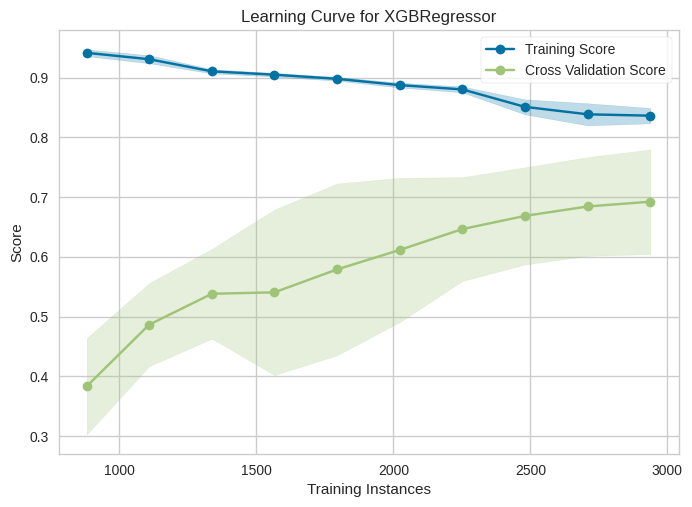

In [48]:
plot_model(final_model, plot = 'learning')

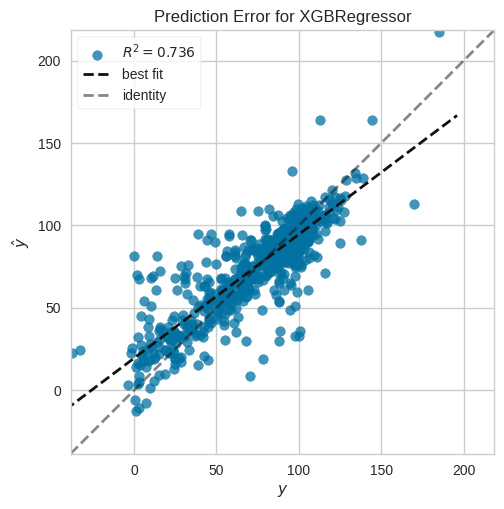

In [49]:
plot_model(final_model, plot = 'error')

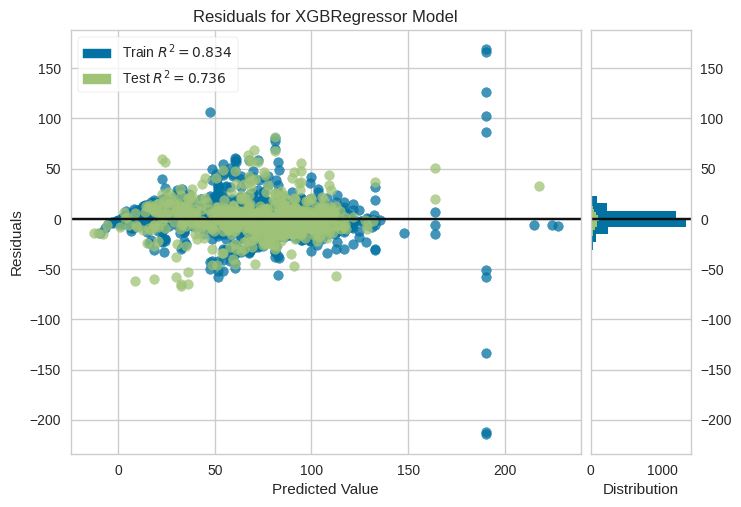

In [50]:
plot_model(final_model, plot = 'residuals')

### Feature importance plot

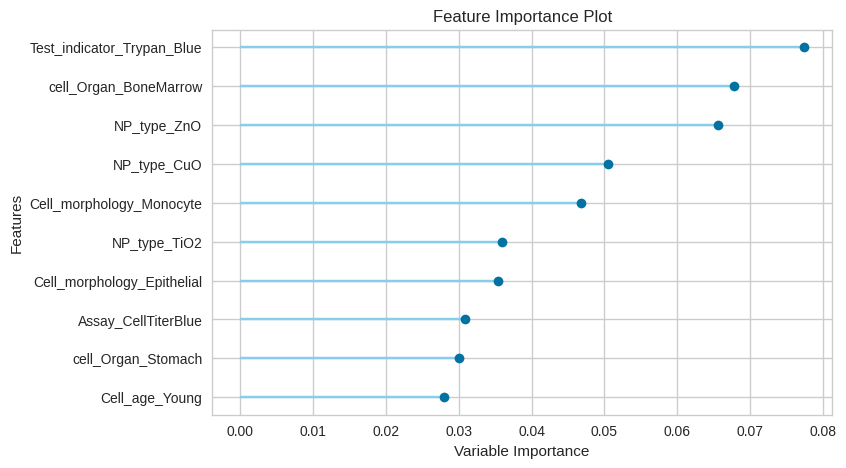

In [51]:
plot_model(final_model, plot = 'feature')

### Save the model to file

In [52]:
save_config('output/models/'+model_name+'_regression_config.cfg')

In [53]:
save_model(final_model, 'output/models/'+model_name+'_regression_model.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, m